<a href="https://colab.research.google.com/github/anaguilarar/WeatherSoilDataProcessor/blob/main/google_colab_examples/dssat_spatial_crop_simulation_pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/anaguilarar/WeatherSoilDataProcessor.git

import os
os.chdir('/content/WeatherSoilDataProcessor')

!pip install -r /content/WeatherSoilDataProcessor/requirements.txt

Cloning into 'WeatherSoilDataProcessor'...
remote: Enumerating objects: 2335, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (210/210), done.
remote: Total 2335 (delta 152), reused 120 (delta 42), pack-reused 2082 (from 2)
Receiving objects: 100% (2335/2335), 125.12 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (1839/1839), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of rioxarray to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
!pip install hvplot panel param geoviews bokeh jupyter_bokeh -U
from google.colab import output
output.enable_custom_widget_manager()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.7.3


# Run spatial Crop Simulation using at pixel-scale resolution

In this example, we show how to simulate the potential yield of a specific crop at a fine spatial resolution (250m), aligned with the SoilGrids project resolution. The simulation requires detailed information on soil and weather conditions, as well as specified management practices.

## Repository Structure
The repository consists of three main components:

1. [**Download Spatial Data:**](#downloaddata)  
  - Weather Data
  - Soil Data

2. [**Data Cube Creation:**](#datacube)
  - Set configuration parameters
  - Spatial visualization
  - Export data as NetCDF files

3. [**Crop Modeling Using the DSSAT Model:**](#cropmodel)
  - Configuration file setup
  - Running DSSAT
  - Plotting the results

## 1. Download Spatial Data<a id="downloaddata"></a>



### Weather Data

In this section, we will download historical weather data . The information will be downloaded mainly from two sources [CHIRPS](https://www.chc.ucsb.edu/data/chirps) and [AgERA5](https://cds.climate.copernicus.eu/datasets/sis-agrometeorological-indicators?tab=overview).

To access AgERA5 data, users must provide account credentials. This requires two key pieces of information:

- Email – The email address used to register the AgERA5 account.
- API Code – A unique code available in the profile settings after account creation.

The following command is used to authenticate and access AgERA5 data:

In [1]:
YOURUSERAPICODE = '06d3e721-5caf-4603-87ce-4a20dac9b6aa'#
YOUREMAIL = 'andres.aguilar@cgiar.org'

with open("/root/.cdsapirc", "w") as f:
  f.write("url: https://cds.climate.copernicus.eu/api\nkey: {}\nemail: ".format(YOURUSERAPICODE, YOUREMAIL))

After, we set the configuration dictionary that defines the parameters for the weather data download, such as the time period, geographical extent, and the output folder path.

In [9]:
import os
os.chdir('/content/WeatherSoilDataProcessor')

import geopandas as gpd
from omegaconf import OmegaConf

from spatialdata.climate_data import MLTWeatherDataCube, ClimateDataDownload
from spatialdata.gis_functions import get_boundaries_from_path

configuration_info = {
    'DATES': {
        'starting_date':'2000-01-01',
        'ending_date': '2024-12-31'},
    'SPATIAL_INFO': {
          'spatial_file': None,
          'extent': None
    },
    'WEATHER': { ## weather information
        'variables': { # variables to download
              'precipitation': {'mission': 'chirps', 'source': 'chirps'},
              #'solar_radiation': {'mission': 'agera5', 'source': 'agera5'},
              #'temperature_tmax': {'mission': 'agera5', 'source': 'agera5'},
              #'temperature_tmin': {'mission': 'agera5', 'source': 'agera5'}
        },
    },
    'GENERAL': {
        'suffix': "mwi",   # ISO3 code
        'ncores': 0,
    },
    'PATHS':{
        'output_path': 'weather/'
    }
}

config = OmegaConf.create(configuration_info)
config.SPATIAL_INFO

{'spatial_file': None, 'extent': None}

In [11]:
import requests

if config.SPATIAL_INFO.get('spatial_file',None):
  extent = get_boundaries_from_path(config.SPATIAL_INFO.get('spatial_file',None), round_numbers = True)
elif config.GENERAL.get('suffix', None):
  country = config.GENERAL.suffix.upper()
  boundary_type = 'ADM0'
  url = f"https://www.geoboundaries.org/api/current/gbOpen/{country}/{boundary_type}/"
  meta = requests.get(url).json()
  extent = get_boundaries_from_path(meta["gjDownloadURL"], round_numbers = True)

else:
    extent = config.SPATIAL_INFO.extent

print(f"from {config.DATES.starting_date} to {config.DATES.ending_date}" )
climatedata = ClimateDataDownload(starting_date= config.DATES.starting_date,
                                    ending_date= config.DATES.ending_date,
                                    xyxy= extent,
                                    output_folder= config.PATHS.output_path)

climatedata.download_weather_information(config.WEATHER.variables, suffix_output_folder=config.GENERAL.suffix, ncores = config.GENERAL.ncores)

Streaming output truncated to the last 5000 lines.
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2011/chirps-v2.0.2011.04.25.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2011/chirps-v2.0.2011.04.26.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2011/chirps-v2.0.2011.04.27.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2011/chirps-v2.0.2011.04.28.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2011/chirps-v2.0.2011.04.29.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2011/chirps-v2.0.2011.04.30.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2011/chirps-v2.0.2011.05.01.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2011/chirps-v2.0.2011.05.02.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2011/chirps-v2.0.2011.05.03.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/glo

### Soil Data

In this section, we will download soil data information for different depths. Currently the information is downloaded from [SoilGrids](https://soilgrids.org/) project.


In [12]:
from spatialdata.soil_data import SoilGridDataDonwload
from spatialdata.gis_functions import get_boundaries_from_path

configuration_info = {

    'SPATIAL_INFO': {
          'spatial_file': None,
          'extent': None,
          'crs': 'ESRI:54052' ## soilgrids proejection system
    },
    'SOIL': { ## weather information
          'variables': ["clay",  "sand", "silt", "cec", "bdod", "cfvo", "nitrogen", "phh2o", "soc","wv0010","wv0033", "wv1500"],
          'depths': ["0-5","5-15","15-30","30-60"]
    },
    'GENERAL': {
        'suffix': 'mwi'
    },
    'PATHS':{
        'output_path': 'soil/'
    }
}

config = OmegaConf.create(configuration_info)
config.SPATIAL_INFO

{'spatial_file': None, 'extent': None, 'crs': 'ESRI:54052'}

In [13]:

if config.SPATIAL_INFO.get('spatial_file',None):
  extent = get_boundaries_from_path(config.SPATIAL_INFO.get('spatial_file',None), crs = config.SPATIAL_INFO.crs, round_numbers = True)
elif config.GENERAL.get('suffix', None):
  country = config.GENERAL.suffix.upper()
  boundary_type = 'ADM0'
  url = f"https://www.geoboundaries.org/api/current/gbOpen/{country}/{boundary_type}/"
  meta = requests.get(url).json()
  extent = get_boundaries_from_path(meta["gjDownloadURL"],crs = config.SPATIAL_INFO.crs, round_numbers = True)

else:
    extent = config.SPATIAL_INFO.extent


outputpath = os.path.join(config.PATHS.output_path, config.GENERAL.suffix)

soildata = SoilGridDataDonwload(soil_layers= config.SOIL.variables,
                            depths= config.SOIL.depths,
                            output_folder= outputpath)

soildata.download_soilgrid(boundaries= extent)

File created: clay_0-5cm_mean.tif 
File created: clay_5-15cm_mean.tif 
File created: clay_15-30cm_mean.tif 
File created: clay_30-60cm_mean.tif 
File created: sand_0-5cm_mean.tif 
File created: sand_5-15cm_mean.tif 
File created: sand_15-30cm_mean.tif 
File created: sand_30-60cm_mean.tif 
File created: silt_0-5cm_mean.tif 
File created: silt_5-15cm_mean.tif 
File created: silt_15-30cm_mean.tif 
File created: silt_30-60cm_mean.tif 
File created: cec_0-5cm_mean.tif 
File created: cec_5-15cm_mean.tif 
File created: cec_15-30cm_mean.tif 
File created: cec_30-60cm_mean.tif 
File created: bdod_0-5cm_mean.tif 
File created: bdod_5-15cm_mean.tif 
File created: bdod_15-30cm_mean.tif 
File created: bdod_30-60cm_mean.tif 
File created: cfvo_0-5cm_mean.tif 
File created: cfvo_5-15cm_mean.tif 
File created: cfvo_15-30cm_mean.tif 
File created: cfvo_30-60cm_mean.tif 
File created: nitrogen_0-5cm_mean.tif 
File created: nitrogen_5-15cm_mean.tif 
File created: nitrogen_15-30cm_mean.tif 
File created: 

File created: wv0010_0-5cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0010/wv0010_5-15cm_mean.tif


File created: wv0010_5-15cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0010/wv0010_15-30cm_mean.tif


File created: wv0010_15-30cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0010/wv0010_30-60cm_mean.tif


File created: wv0010_30-60cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0033/wv0033_0-5cm_mean.tif


File created: wv0033_0-5cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0033/wv0033_5-15cm_mean.tif


File created: wv0033_5-15cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0033/wv0033_15-30cm_mean.tif


File created: wv0033_15-30cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0033/wv0033_30-60cm_mean.tif


File created: wv0033_30-60cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv1500/wv1500_0-5cm_mean.tif


File created: wv1500_0-5cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv1500/wv1500_5-15cm_mean.tif


File created: wv1500_5-15cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv1500/wv1500_15-30cm_mean.tif


File created: wv1500_15-30cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv1500/wv1500_30-60cm_mean.tif


File created: wv1500_30-60cm_mean.tif 


## 2. Data Cube Creation<a id="datacube"></a>

### Set configuration parameters
To implement this, it is necessary to have spatial information for soil and climate. We can create a datacube with dimensions height, width, channel, and date for weather, and height, width, channel, and depth for soil.

An example of the spatial configuration is available in the options folder. Here, we will define it as a dictionary variable.

In [3]:
import warnings
import requests
# To ignore all DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
## creating
import os
os.chdir('/content/WeatherSoilDataProcessor')
from crop_modeling.spatial_process import SpatialData

configuration_info = {
    'GENERAL_INFO': {'projected_crs':'ESRI:54052',
                     'suffix': 'mwi'},
    'SPATIAL_VECTOR': {
        #'boundaries': "data/country.shp", # geo spatial file that will define the spatial boundaries
        'boundaries': None
    },
    'WEATHER': { ## weather information
        'setup_parameters': { # parameters to create the datacube
            'paths':{ # path that allows each one of the meteorological variables information
                'precipitation': "weather/precipitation_hnd_raw",
                'srad': "weather/solar_radiation_hnd_raw",
                'tmax': "weather/temperature_tmax_hnd_raw",
                'tmin': "weather/temperature_tmin_hnd_raw"
            },
            'crs': 'EPSG:4326', ## spatial coordinates system
            'period': ['2000-01-01', '2009-12-31'] ,
            'reference_variable': 'precipitation' # variable used as spatial resolution reference
        },
        'data_cube_path' : None # path to the data cube information if it was already created
    },
    'SOIL': {
        'setup_parameters': { # parameters to create the datacube
            'path': "soil/hnd/",
            'variables': ["clay",  "sand", "silt", "cec", "bdod", "cfvo", "nitrogen", "phh2o", "soc","wv0010","wv0033", "wv1500"],
            'depths': ["0-5","5-15","15-30","30-60"],
            'crs': 'ESRI:54052', ## SOILGRIDS spatial coordinates system
            'reference_variable': 'sand' # variable used as spatial resolution reference
        },
        'data_cube_path' : None # path to the data cube information if it was already created
    }
}

In [5]:
## creating boundaries file if there is not one
import geopandas as gpd
if configuration_info['SPATIAL_VECTOR'].get('boundaries', None) is None:
  country = configuration_info['GENERAL_INFO']['suffix'].upper()
  url = f"https://www.geoboundaries.org/api/current/gbOpen/{country}/ADM0/"
  meta = requests.get(url).json()
  data_country = gpd.read_file(meta["gjDownloadURL"])
  cs = configuration_info['GENERAL_INFO']['suffix'] = configuration_info['GENERAL_INFO']['suffix']
  data_country.to_file(f'data/country_{cs}.shp')
  configuration_info['SPATIAL_VECTOR']['boundaries'] = f'data/country_{cs}.shp'
  print(cs)
  configuration_info['WEATHER']['setup_parameters']['paths']['precipitation'] = f"weather/precipitation_{cs}_raw"
  configuration_info['WEATHER']['setup_parameters']['paths']['srad'] = f"weather/solar_radiation_{cs}_raw"
  configuration_info['WEATHER']['setup_parameters']['paths']['tmax'] = f"weather/temperature_tmax_{cs}_raw"
  configuration_info['WEATHER']['setup_parameters']['paths']['tmin'] = f"weather/temperature_tmin_{cs}_raw"
  configuration_info['SOIL']['setup_parameters']['path'] = f"soil/{cs}"


mwi


In [6]:

# Initialize SpatialData with the configuration dictionary
spdata = SpatialData(configuration_dict=configuration_info)

# Retrieve climate data
spdata.get_climate_data()


weather/precipitation_mwi_raw/2000
weather/precipitation_mwi_raw/2001
weather/precipitation_mwi_raw/2002
weather/precipitation_mwi_raw/2003
weather/precipitation_mwi_raw/2004
weather/precipitation_mwi_raw/2005
weather/precipitation_mwi_raw/2006
weather/precipitation_mwi_raw/2007
weather/precipitation_mwi_raw/2008
weather/precipitation_mwi_raw/2009
weather/solar_radiation_mwi_raw/2000
weather/solar_radiation_mwi_raw/2001
weather/solar_radiation_mwi_raw/2002
weather/solar_radiation_mwi_raw/2003
weather/solar_radiation_mwi_raw/2004
weather/solar_radiation_mwi_raw/2005
weather/solar_radiation_mwi_raw/2006
weather/solar_radiation_mwi_raw/2007
weather/solar_radiation_mwi_raw/2008
weather/solar_radiation_mwi_raw/2009
weather/temperature_tmax_mwi_raw/2000
weather/temperature_tmax_mwi_raw/2001
weather/temperature_tmax_mwi_raw/2002
weather/temperature_tmax_mwi_raw/2003
weather/temperature_tmax_mwi_raw/2004
weather/temperature_tmax_mwi_raw/2005
weather/temperature_tmax_mwi_raw/2006
weather/temper

100%|██████████| 3653/3653 [00:03<00:00, 966.88it/s]


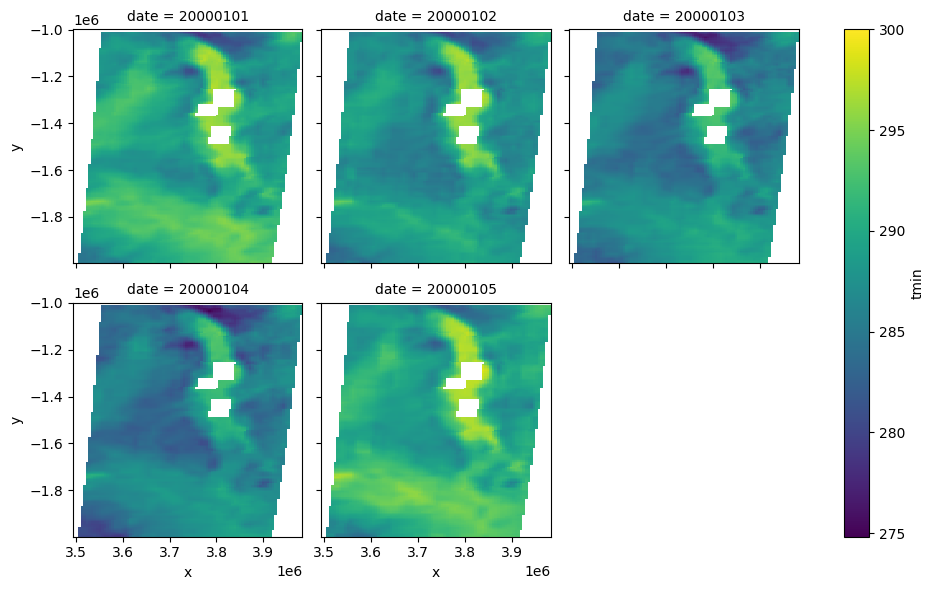

In [7]:
## plots

g_simple = spdata.climate.tmin.isel(date = list(range(5))).plot(x="x", y="y", col="date", col_wrap=3, vmax = 300)

In [8]:
spdata._save_asnc(spdata.climate, fn = f'weather/weather_{cs}.nc')

In [9]:
spdata.climate = None

In [ ]:

# Retrieve soil data
spdata.get_soil_data()

# texture values in soil grids data is multiply by 10
g_simple = spdata.soil.clay.plot(x="x", y="y", col="depth", col_wrap=2, vmax = 600)

 75%|███████▌  | 3/4 [01:21<00:27, 27.23s/it]

In [ ]:
# save data as datacubes
spdata._save_asnc(spdata.soil, fn = f'soil/soil_{cs}.nc')


## 3. Crop Modeling Using the DSSAT Model<a id="cropmodel"></a>




### Spatial data

The previous steps serve as a guide for obtaining the spatial datacubes data, (climate, and weather). In the following example, we will use datacubes that were previously processed for the entire country. These files contain historical climate data spanning a 34-year period. They are available in a Google Drive folder, so you will only need to download them using the gdown function.


In [ ]:
import os
soil_fileid = '1-zibd97Cr1LcPvrrv0ICZur1SWU_WVCn'
weather_fileid = '1AoEy49mcuBUS8fs4OFdNEH4E90A33LKD'

if not os.path.exists('hnd_soilgrids.nc'):
  !gdown --id {soil_fileid} --output hnd_soilgrids.nc

if not os.path.exists('hnd_weather.nc'):
  !gdown --id {weather_fileid} --output hnd_weather.nc

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-zibd97Cr1LcPvrrv0ICZur1SWU_WVCn
From (redirected): https://drive.google.com/uc?id=1-zibd97Cr1LcPvrrv0ICZur1SWU_WVCn&confirm=t&uuid=30d87b91-e105-4189-94f9-2a30965f702b
To: /content/hnd_soilgrids.nc
100% 191M/191M [00:02<00:00, 76.5MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1AoEy49mcuBUS8fs4OFdNEH4E90A33LKD
From (redirected): https://drive.google.com/uc?id=1AoEy49mcuBUS8fs4OFdNEH4E90A33LKD&confirm=t&uuid=6f7b59ab-55f2-4ba9-9de5-7573d322e811
To: /content/hnd_weathe

### Configuration file setup

To specify that the analysis will be done at pixel-scale, we set 'pixel' in the configuration dictionary.

Other parameters to configure include crop parameters and management practices.
Below is an example of how to define these parameters. For more examples, please check the options/dssat_options folder.

In [ ]:
import os
os.chdir('/content/WeatherSoilDataProcessor')
from crop_modeling.spatial_process import SpatialCM
import numpy as np
import pandas as pd

cm_configuration = {
    'GENERAL_INFO': {
        'country': 'Honduras',
        'country_code': 'HND', # crountry code
        'working_path': 'runs', # the model outputs will be located in this path
        'ncores': 15,
        'model': 'dssat',
        'bin_path': None
    },
    'SPATIAL_INFO':{
        'geospatial_path': '/content/WeatherSoilDataProcessor/data/tb_limitealdeas.shp', # spatial file that contains the region of interest
        'feature_name': 'GEOCODIGO', ## an unique code that represent each region of interest
        'aggregate_by' : 'pixel',
        'soil_path' : '/content/hnd_soilgrids.nc',
        'weather_path': '/content/hnd_weather.nc',
        'scale_factor': 10 # scale factor for soil and weather spatial resolution combination
    },
    'CROP': {
        'name': 'Maize', # crop name
        'cultivar': 'IB1072', # cultivar
        'cultivar_file': None # optional for the cases that you have a cultivar that is not in DSSATTools default cultivars
    },
    'MANAGEMENT':{
        'planting_date': '1991-03-01',
        'harvesting_date': None,
        'plantingWindow': 30, # planting window in weeks
        'fertilizer_schedule': {
            'days_after_planting': None,
            'npk': None
        },
        'index_soilwat': 1,
        'template': 'crop_modeling/dssat/exp_files/KEAG8104.MZX'
    }
}



/usr/local/lib/python3.11/dist-packages/DSSATTools/__init__.py:88: DeprecationWarning: DSSATTools version 3 is soon to be released. The new version is a major upgrade and will not be backwards compatible. This will be the latest release of DSSATTools version 2.
  warnings.warn(


### Running DSSAT

In [ ]:
# Initialize the spatial crop modeling class
cm_sp = SpatialCM(configuration_dict=cm_configuration)
geocode = '150149'
# Specify the region of interest by its geocode this can be also done using the feature index
roi = cm_sp.geo_features.loc[cm_sp.geo_features['GEOCODIGO']==str(geocode)]
roi_name = roi[cm_sp.config.SPATIAL_INFO.feature_name].values[0]
roi
#cm_sp.geo_features['GEOCODIGO']

loaded from /content/hnd_soilgrids.nc
loaded from /content/hnd_weather.nc


,GEOCODIGO,ALDEA,COD_ALDEA,COD_MUNI,COD_DEPTO,KM2,DENSIDAD,MUNI,DEPTO,AREA_HA,geometry
932,150149,Pusunca o San Agustín,150149,1501,15,20.8814,51.0981,Juticalpa,Olancho,2088.138366,"POLYGON ((-86.11061 14.70222, -86.10999 14.702..."


In [ ]:

import shutil
if os.path.exists(f'/content/WeatherSoilDataProcessor/runs/{geocode}'):
  shutil.rmtree(f'/content/WeatherSoilDataProcessor/runs/{geocode}', ignore_errors=False, onerror=None)

In [ ]:
cm_sp.set_up_folders(site = roi_name)

# Create soil and weather files for the selected region
workingpath = cm_sp.create_roi_sp_data(
    roi= roi,
    export_spatial_data= True
)
if workingpath is not None:
    # Locate environmental working paths
    cm_sp.model.find_envworking_paths(cm_sp._tmp_path, 'WTH')

    # Set up crop files
    cm_sp.model.set_up_crop(crop=cm_sp.crop, cultivar=cm_sp.cultivar)

    # Set up management files
    cm_sp.model.set_up_management(crop=cm_sp.crop, cultivar=cm_sp.cultivar, **cm_sp.config.MANAGEMENT)

    # run the simulation
    dssath_path = cm_sp.config.GENERAL_INFO.get('dssat_path', None)
    completed_sims =cm_sp.model.run(cm_sp.model.crop_code, crop=cm_sp.crop,planting_window=cm_sp.config.MANAGEMENT.plantingWindow,
                                    ncores = cm_sp.config.GENERAL_INFO.ncores,
                                        bin_path = cm_sp.config.GENERAL_INFO.bin_path, remove_tmp_folder=True)
    print(completed_sims)
else:
    print('there is no information')

100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Configuration file written: runs/150149/114/experimental_file_config.yaml
experimental file created: ['runs/150149/114/EXPS0001.MZX']
Configuration file written: runs/150149/100/experimental_file_config.yaml
experimental file created: ['runs/150149/100/EXPS0001.MZX']
Configuration file written: runs/150149/113/experimental_file_config.yaml
experimental file created: ['runs/150149/113/EXPS0001.MZX']
Configuration file written: runs/150149/93/experimental_file_config.yaml
experimental file created: ['runs/150149/93/EXPS0001.MZX']
Configuration file written: runs/150149/127/experimental_file_config.yaml
experimental file created: ['runs/150149/127/EXPS0001.MZX']
Configuration file written: runs/150149/116/experimental_file_config.yaml
experimental file created: ['runs/150149/116/EXPS0001.MZX']
Configuration file written: runs/150149/85/experimental_file_config.yaml
experimental file created: ['runs/150149/85/EXPS0001.MZX']
Configuration file written: runs/150149/111/experimental_file_conf

  2%|▏         | 1/51 [00:36<30:20, 36.41s/it]

### Crop simulation outputs

After completing the simulation, the next step is to generate the output maps.


In [ ]:
from crop_modeling.dssat.output import update_dssat_data_using_path
from crop_modeling.spatial_process import create_mlt_yield_raster
import rioxarray as rio
import matplotlib.pyplot as plt


refraster = rio.open_rasterio(os.path.join(cm_sp._tmp_path,'ref_raster.tif'))
model_data = update_dssat_data_using_path(cm_sp._tmp_path)

mlt_pot_yield = create_mlt_yield_raster(refraster, model_data, ycol_name='HWAH')


### Plotting the results

In [ ]:
import hvplot.xarray
import holoviews as hv
import panel as pn

hv.extension("bokeh")
minlim = mlt_pot_yield.HWAH.min().values
maxlim = mlt_pot_yield.HWAH.max().values

mltmap = mlt_pot_yield.HWAH.hvplot.image(x='x', y='y', groupby = 'date',frame_height = 600, frame_width= 400, cmap='YlGnBu', fontscale=1.6, crs='EPSG:4326', tiles = 'EsriImagery', clim=(minlim,maxlim))

dmap_panel = pn.panel(mltmap)
dmap_panel


### Exporting the results

In [ ]:
from crop_modeling.utils.process import get_crs_fromxarray,set_encoding, check_crs_inxrdataset

dcengine = 'netcdf4'
encoding = set_encoding(mlt_pot_yield)
xrdata = check_crs_inxrdataset(mlt_pot_yield)
xrdata.to_netcdf(f'simlations_{geocode}.nc', encoding = encoding, engine = dcengine)



In [ ]:
import hvplot.pandas
boxplot = mlt_pot_yield.HWAH.hvplot.box('HWAH', by=['date'], rot=90, box_fill_color='lightblue', width=1600, height=450).opts(ylim=(1285,9969))
dmap_panel = pn.panel(boxplot)
dmap_panel

In [ ]:
from crop_modeling.utils.output_transforms import summarize_spatial_yields_by_time_window

summ_yield  =summarize_spatial_yields_by_time_window(xrdmlt_pot_yieldata, plantingWindow= 30)
